In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from DTA.plotting import *
from DTA.utils import *
from DTA.Site import Site
from DTA.SymmetricSite import SymmetricSite
from DTA.SiteAcrossReplicas import SiteAcrossReplicas
from DTA.density import *
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
my_cmap = make_custom_colormap()
plt.rcParams['axes.grid'] = False 

## EDIT THESE VARIABLES

In [15]:
root_path = Path("/home/js2746/ELIC5/simulations/PC_CL/5%CDL/")
DPPC_root_path = Path("/home/js2746/ELIC5/simulations/DPPC/")
DPPC_bulk_root_path = Path("/home/js2746/ELIC5/simulations/DPPC_bulk/")
system_names = ["CDL1", "POPC"] # or the names of choice
leaflets = ['upp', 'low'] # analyze both leaflets (default)
replicas = ["rep2", "rep3", "rep4", "rep5"] # replicas as identified in the "root" directory
helix_definitions = root_path.joinpath(replicas[0]) #where are the coordinates for the transmembrane helices?
max_enrichment = 3 # how high do you want your heat map to go?
hmap_height = 6
hmap_width = 6

## MAKE A HEATMAP OF DENSITY ENRICHMENT

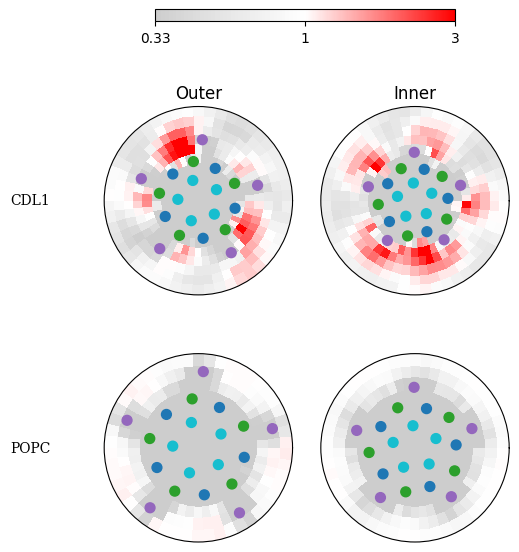

In [16]:
fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, my_cmap, max_enrichment, helix_definitions, (hmap_height, hmap_width), leaflets, replicas, root_path)
plt.savefig(root_path.joinpath("enrichments.pdf"), bbox_inches='tight')   

## CHOOSE A SITE (OR SITES)

#### Step 1: Create a Site object
#### Step 2: Add a list of bin coordinates
#### Step 3 (optional): If symmetric site is desired, make a SymmetricSite
#### Step 4: Outline the site on the heatmap with outline_site()
#### Step 5: Go back to step 2 and iterate as necessary

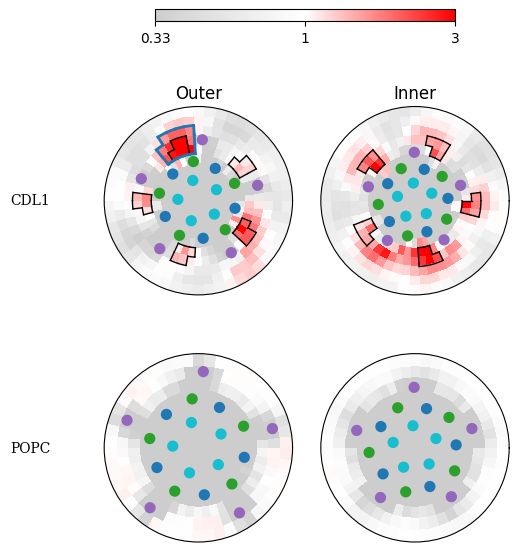

In [17]:
site1 = Site(name="inner M1-M4", leaflet_id=2, temperature=320) # step 1
site1.bin_coords = [(5, 8), (5, 9), (6, 9), (6, 8), (6, 10)] # step 2
symm_site1 = SymmetricSite(symmetry=5, base_site=site1, Ntheta=grid_dims.Ntheta) #step 3

site2 = Site(name="outer M3-M4", leaflet_id=1, temperature=320) # step 1
site2.bin_coords = [(5, 4), (5, 5), (5, 6), (6, 5), (6, 4)] # step 2
symm_site2 = SymmetricSite(symmetry=5, base_site=site2, Ntheta=grid_dims.Ntheta) #step 3

site3 = Site(name="outer leaflet big blob", leaflet_id=1, temperature=320) # step 1
site3.bin_coords = [(5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (7, 13), (7, 14), (7, 15), (7, 16)] # step 2

fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, my_cmap, max_enrichment, helix_definitions, (hmap_height, hmap_width), leaflets, replicas, root_path)

axes[0] = outline_site(axes[0], symm_site2, grid_dims) #step 4
axes[0] = outline_site(axes[0], site3, grid_dims, color='tab:blue', linewidth=2) # step 4
axes[1] = outline_site(axes[1], symm_site1, grid_dims) # step 4

plt.savefig(root_path.joinpath("enrichments_withSites.pdf"), bbox_inches='tight')

## Find accessible area

In [ ]:
DPPC_outer = DPPC_root_path.joinpath(f"DPPC.upp.dat")
DPPC_outer_counts, grid_dims, outer_system_info = parse_tcl_dat_file(DPPC_outer, bulk=False)
DPPC_inner = DPPC_root_path.joinpath(f"DPPC.low.dat")
DPPC_inner_counts, grid_dims, inner_system_info = parse_tcl_dat_file(DPPC_inner, bulk=False)

## For each site above, perform the following:
#### Step 1: Create a duplicate site, but name it 'DPPC'

In [22]:
DPPC_site1 = Site(name="DPPC inner M1-M4", leaflet_id=2, temperature=320)
DPPC_site1.bin_coords = [(5, 8), (5, 9), (6, 9), (6, 8), (6, 10)]
DPPC_symm_site1 = SymmetricSite(symmetry=5, base_site=DPPC_site1, Ntheta=grid_dims.Ntheta)

#### Step 2: add the DPPC counts from the correct leaflet

In [31]:
DPPC_symm_site1.update_counts_histogram(bulk=False, counts_data=DPPC_inner_counts)

#### Step 3a: Calculate the geometric area of the site

In [ ]:
site1_geom_area = round(DPPC_site1.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site1_geom_area} A^2")

Initial guess for accessible area is geometric area:
96 A^2


#### Step 3b: Plot the histogram of DPPC beads in your site

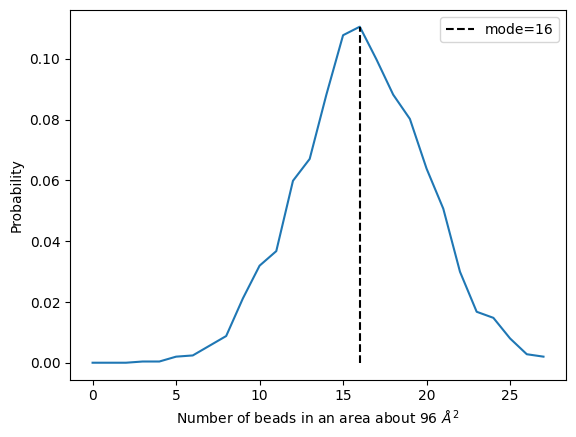

In [34]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.site_counts_histogram, site1_geom_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step 4a: Edit density_threshold_affinity/accessible_area/do_get_counts.tcl to run on your DPPC bulk system
#### Step 4b: Load your bulk DPPC simulation (no protein) in VMD
#### Step 4c: Run do_get_counts.tcl
#### Step 4e: Load the bulk counts into this notebook

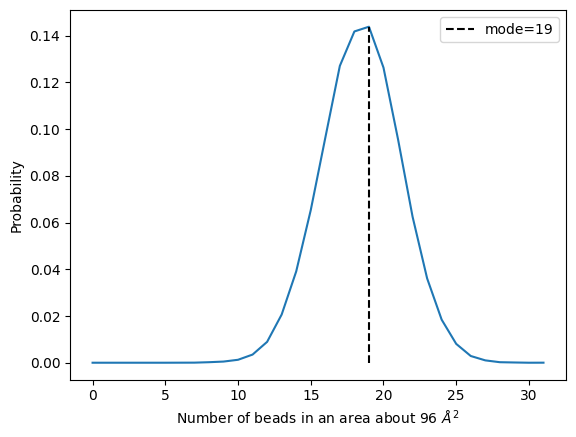

In [37]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site1_geom_area}.out"), bulk=True)
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_symm_site1.bulk_counts_histogram, f"{site1_geom_area}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step 5a: Predict a better guess for the true accessible area of the site

In [36]:
better_guess = round(DPPC_symm_site1.predict_accessible_area(site1_geom_area))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 81 A^2


#### Step 5b: Plot the new distribution with a smaller area: do the modes match?

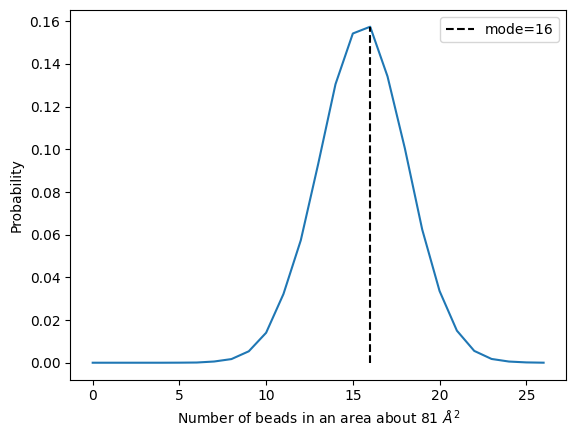

In [ ]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_symm_site1.bulk_counts_histogram, f"{better_guess}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step 5c: If yes, congratulations! You have identified the accessible area of your site. If no, try running do_get_counts with a smaller area until the modes match.

## For completeness, we have calculated the accessible areas for our sites 2 and 3 as well

Initial guess for accessible area is geometric area: 93 A^2


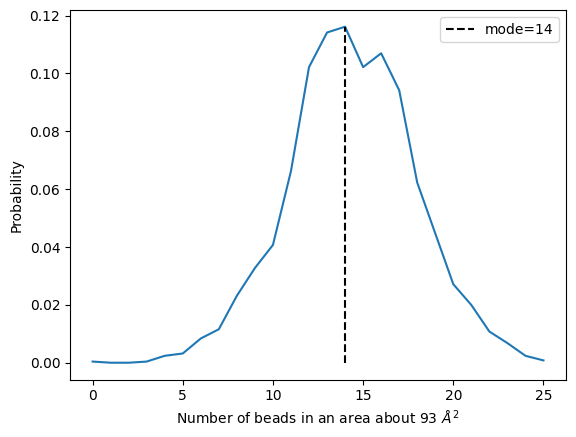

In [46]:
DPPC_site2 = Site(name="DPPC outer M3-M4", leaflet_id=1, temperature=320)
DPPC_site2.bin_coords = [(5, 4), (5, 5), (5, 6), (6, 5), (6, 4)]
DPPC_symm_site2 = SymmetricSite(symmetry=5, base_site=DPPC_site2, Ntheta=grid_dims.Ntheta)
DPPC_symm_site2.update_counts_histogram(bulk=False, counts_data=DPPC_outer_counts)
site2_geom_area = round(DPPC_site2.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site2_geom_area} A^2")
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site2.site_counts_histogram, site2_geom_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

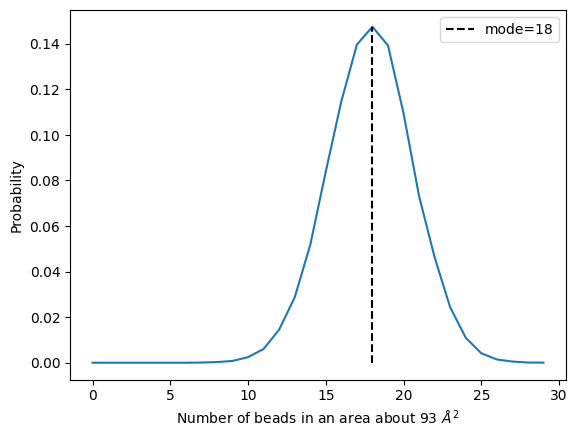

In [47]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site2_geom_area}.out"), bulk=True)
DPPC_symm_site2.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_symm_site2.bulk_counts_histogram, f"{site2_geom_area}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

In [48]:
better_guess = round(DPPC_symm_site2.predict_accessible_area(site2_geom_area))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 72 A^2


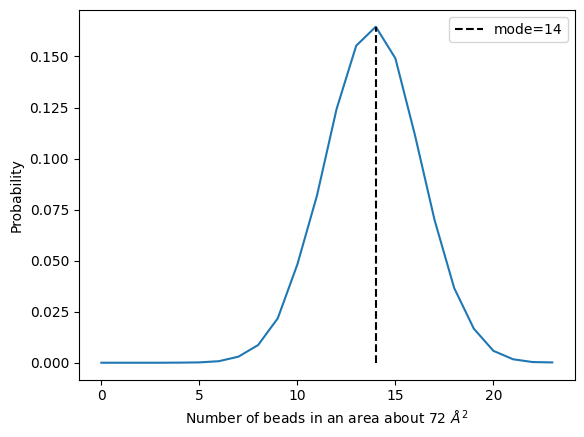

In [49]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_symm_site2.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_symm_site2.bulk_counts_histogram, f"{better_guess}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

Initial guess for accessible area is geometric area: 283 A^2


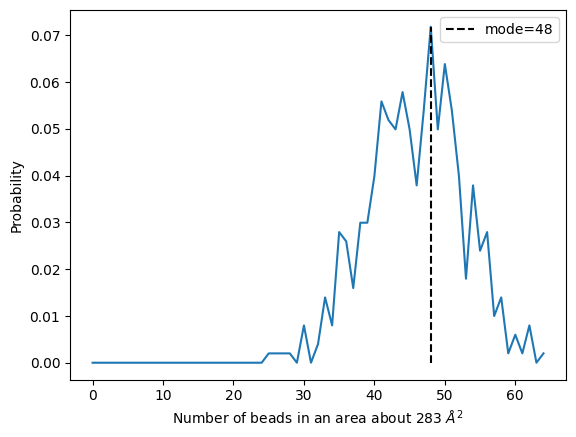

In [50]:
DPPC_site3 = Site(name="DPPC outer big blob", leaflet_id=1, temperature=320)
DPPC_site3.bin_coords = [(5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (7, 13), (7, 14), (7, 15), (7, 16)]
DPPC_site3.update_counts_histogram(bulk=False, counts_data=DPPC_outer_counts)
site3_geom_area = round(DPPC_site3.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site3_geom_area} A^2")
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_site3.site_counts_histogram, site3_geom_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

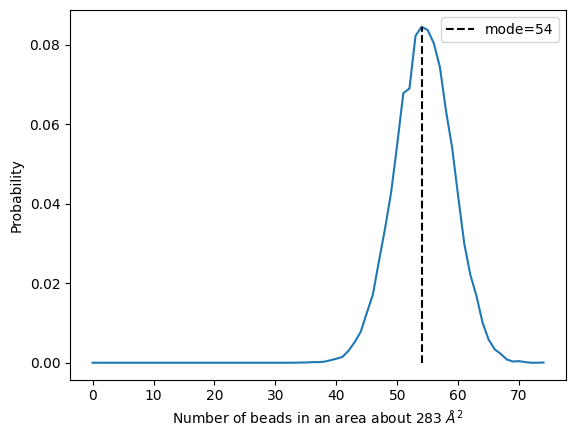

In [51]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site3_geom_area}.out"), bulk=True)
DPPC_site3.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_site3.bulk_counts_histogram, f"{site3_geom_area}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

In [52]:
better_guess = round(DPPC_site3.predict_accessible_area(site3_geom_area))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 252 A^2


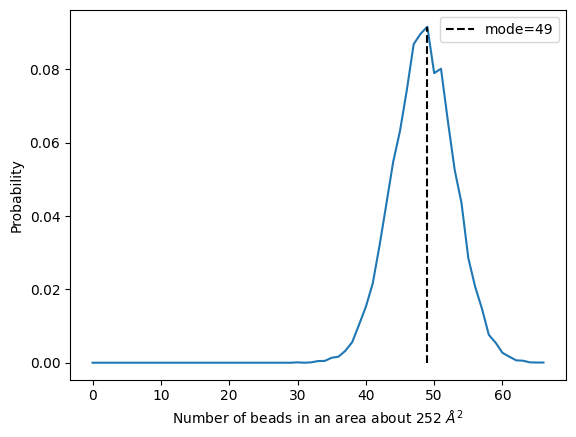

In [53]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_site3.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_site3.bulk_counts_histogram, f"{better_guess}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

In [54]:
better_guess2 = round(DPPC_site3.predict_accessible_area(better_guess))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess2} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 247 A^2


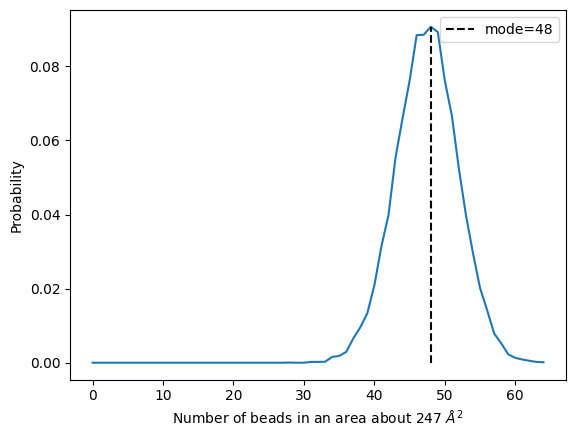

In [55]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess2}.out"), bulk=True)
DPPC_site3.update_counts_histogram(True, DPPC_bulk_counts)
fig2,ax2 = plt.subplots()
ax2 = plot_histogram(ax2, DPPC_site3.bulk_counts_histogram, f"{better_guess2}", plot_probability=True)
plt.show()
plt.clf()
plt.close()